In [1]:
# import pandas as pd
# from datetime import datetime, timedelta
# # خواندن فایل CSV
# df = pd.read_csv("power_code.csv")
# # تبدیل تاریخ با فرمت‌های مختلف
# df['DATE_MILADI'] = pd.to_datetime(df['DATE_MILADI'], format='mixed', errors='coerce')

# # حذف ردیف‌هایی که تبدیل تاریخ در آن‌ها ناموفق بوده
# df = df.dropna(subset=['DATE_MILADI'])
# # ساخت ستون جدید DATE با ساعت اصلاح‌شده از ستون HOUR
# df['DATE'] = df.apply(lambda row: row['DATE_MILADI'].replace(hour=int(row['HOUR']) % 24), axis=1)

# # نمایش چند سطر اول برای بررسی
# print(df[['DATE_MILADI', 'HOUR', 'DATE']].head())

# # ذخیره فایل جدید در صورت نیاز
# df.to_csv('updated_file.csv', index=False)

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from darts import TimeSeries
import pandas as pd
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

c:\Users\pishva_r\Anaconda3\envs\test2\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
df = pd.read_csv("../BackUp/updated_file.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='mixed', errors='coerce')
df = df.dropna(subset=['DATE'])

In [3]:
target_date = pd.to_datetime('6/28/2025 1:00:00 AM')
df_filtered = df[(df['UNIT_NO'] == 5) & (df['DATE'] >= target_date)]
print(df_filtered.head())


          ID_NO  HOUR DATE_MILADI DATE_SHAMSI  POWER CODE  UNIT_NO  ID_EBRAZ  \
966286  1490125     1  2025-06-28    1404/4/7    116   SO        5   1427930   
966287  1490126     2  2025-06-28    1404/4/7    116   SO        5   1427931   
966288  1490127     3  2025-06-28    1404/4/7    116   SO        5   1427932   
966289  1490128     4  2025-06-28    1404/4/7    105   SO        5   1427933   
966290  1490129     5  2025-06-28    1404/4/7    105   SO        5   1427934   

       CODE3  MVAR  DAMA  ROTOOBAT   TOTAL                DATE  
966286     A  24.0  26.0      13.0  1050.0 2025-06-28 01:00:00  
966287     A  22.0  25.0      15.0  1052.0 2025-06-28 02:00:00  
966288     A  26.0  23.0      17.0  1059.0 2025-06-28 03:00:00  
966289     A  25.0  24.0      18.0   992.0 2025-06-28 04:00:00  
966290     A  22.0  24.0      18.0   996.0 2025-06-28 05:00:00  


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [5]:
duplicates = df_filtered['DATE'].duplicated().sum()
print(f"duplicates rows: {duplicates}")


duplicates rows: 0


In [6]:
df_filtered = df_filtered.drop_duplicates(subset='DATE')
# df_filtered = df_filtered.groupby('DATE', as_index=False).agg({'POWER': 'mean'})

In [7]:
series = TimeSeries.from_dataframe(
    df_filtered,
    time_col='DATE',
    value_cols='POWER',
    freq='h'  
)

In [10]:
covariates = TimeSeries.from_dataframe(df_filtered, time_col='DATE', value_cols='DAMA', freq='h')

In [11]:
# scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
# series_scaled = scaler.fit_transform(series)

scaler_series = Scaler(MinMaxScaler(feature_range=(0, 1)))
series_scaled = scaler_series.fit_transform(series)
scaler_cov = Scaler(MinMaxScaler(feature_range=(0, 1)))
covariates_scaled = scaler_cov.fit_transform(covariates)

In [12]:
train_ratio = 0.95
# train, test = series_scaled.split_after(train_ratio)


train_series, test_series = series_scaled.split_after(train_ratio)
train_cov, test_cov = covariates_scaled.split_after(train_ratio)

print(f"train data: {len(train_series)} hour")
print(f"test data: {len(test_series)} hour")


train data: 272 hour
test data: 15 hour


In [13]:
# model = RNNModel(
#     model='LSTM', 
#     hidden_dim=100,
#     n_rnn_layers=6,   
#     dropout=0.2, 
#     input_chunk_length=24, 
#     output_chunk_length=12, 
#     training_length=36, 
#     n_epochs=100,
#     random_state=42 
# )

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [15]:
from darts.models import BlockRNNModel

model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_dim=64,
    n_rnn_layers=2,
    dropout=0.2,
    n_epochs=100,
    random_state=42
)

model.fit(
    series=train_series,
    past_covariates=train_cov,
    verbose=True
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.7 K | train
6 | fc              | Sequential       | 780    | train
-------------------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=42)

In [16]:
pred = model.predict(n=len(test_series), series=train_series, past_covariates=covariates_scaled)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)

In [18]:
print(f"RMSE: {rmse(test_series, pred):.2f}")
print(f"MAE: {mae(test_series, pred):.2f}")

RMSE: 3.11
MAE: 2.22


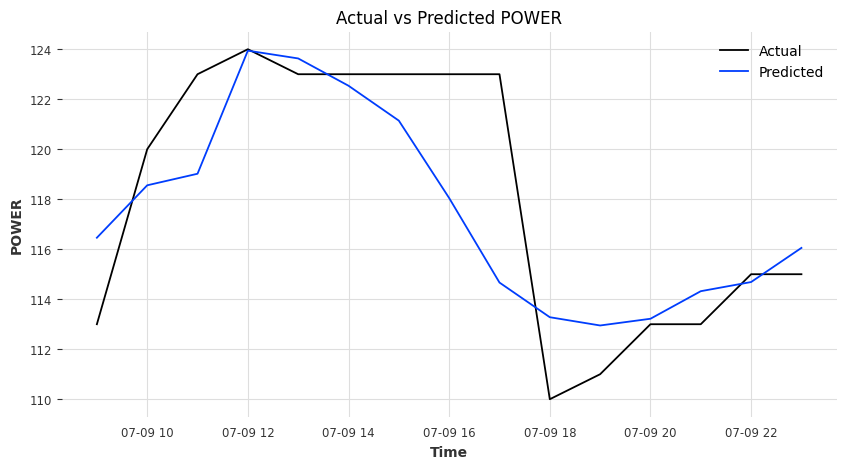

In [19]:
# تبدیل سری‌ها به pandas
df_test = test_series.pd_dataframe()
df_pred = pred.pd_dataframe()

# رسم نمودار
plt.figure(figsize=(10, 5))
plt.plot(df_test.index, df_test['POWER'], label='Actual')
plt.plot(df_pred.index, df_pred['POWER'], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted POWER")
plt.xlabel("Time")
plt.ylabel("POWER")
plt.grid(True)
plt.show()
